In [1]:
import pandas as pd
import numpy as np
from modules import constants
from modules.functions import convert_box_score_dataframe_to_regression_format,add_calculated_metrics_to_preprocessed_dataframe
from sklearn.linear_model import Ridge
from modules.objects import RegressionHub

team_id_name_dict = {v:k for k,v in constants.TEAM_NAME_ID_DICT.items()}

Read in full data filter on D1 games only

In [3]:
full_box_df = pd.read_parquet('parquet_files/box_scores_sports_reference_2024.gzip')
metrics_df = add_calculated_metrics_to_preprocessed_dataframe(full_box_df)
reg_df = convert_box_score_dataframe_to_regression_format(metrics_df)
print(reg_df.shape)
games_df = reg_df.drop(['ortg','drtg','pace','to_pct','opp_to_pct','game_date','ui'],axis = 1).copy()
y_df = reg_df[['ortg','drtg','pace']].copy()

parameter_dict = {}
master_df = pd.DataFrame()
for column in y_df.columns.tolist():
    
    reg = Ridge(alpha=1.5,fit_intercept=True)
    reg.fit(X = games_df ,y = y_df[column].to_numpy())
    reg_results = {"variable":[],f'coef_{column}':[],f'intercept_{column}':[],f'adj_{column}':[]}
    intercept = round(reg.intercept_,2)
    parameter_dict[f"{column}_regression"] = reg
    
    for variable,coefficient in zip(games_df.columns,reg.coef_):
        reg_results[f'intercept_{column}'].append(intercept)
        reg_results['variable'].append(variable)
        reg_results[f'coef_{column}'].append(coefficient)
        reg_results[f'adj_{column}'].append(coefficient + reg.intercept_)
    
    output_df = pd.DataFrame(reg_results)
    output_df = output_df.loc[(output_df.variable.str.startswith("TM")) | (output_df.variable == "home")].copy()
    output_df['tm_id'] = output_df.variable.map(lambda x: x.split("_")[1] if x != 'home' else -1).astype(int)
    output_df['team_name'] = output_df.tm_id.map(lambda x: team_id_name_dict.get(x,"HOME_COURT_ADVANTAGE"))
    output_df = output_df[['team_name',f'intercept_{column}',f'coef_{column}',f'adj_{column}']]
    
    if master_df.empty:
        master_df = output_df.copy()
        continue
    
    master_df = master_df.merge(output_df,on = 'team_name')
    

master_df['adj_nrtg'] = master_df.adj_ortg - master_df.adj_drtg
parameter_dict['regression_dict'] = master_df.set_index('team_name').to_dict(orient='index')
master_df.sort_values('adj_nrtg',ascending=False).reset_index(drop = True)

(9200, 732)


,team_name,intercept_ortg,coef_ortg,adj_ortg,intercept_drtg,coef_drtg,adj_drtg,intercept_pace,coef_pace,adj_pace,adj_nrtg
0,HOUSTON,104.49,13.024951,117.515297,104.49,-21.029947,83.460399,68.97,-3.959870,65.006504,34.054898
1,PURDUE,104.49,20.301064,124.791410,104.49,-10.822213,93.668133,68.97,-0.375772,68.590602,31.123277
2,ARIZONA,104.49,17.011300,121.501645,104.49,-13.088862,91.401483,68.97,4.688235,73.654609,30.100162
3,UCONN,104.49,18.800057,123.290403,104.49,-9.824076,94.666269,68.97,-3.211942,65.754431,28.624133
4,ALABAMA,104.49,20.983388,125.473734,104.49,-7.049400,97.440945,68.97,4.827713,73.794086,28.032788
...,...,...,...,...,...,...,...,...,...,...,...
358,PACIFIC,104.49,-12.070825,92.419521,104.49,11.847665,116.338011,68.97,0.686135,69.652508,-23.918490
359,LINDENWOOD,104.49,-14.846832,89.643513,104.49,9.724407,114.214753,68.97,0.653898,69.620271,-24.571240
360,COPPIN STATE,104.49,-20.939997,83.550349,104.49,4.236700,108.727046,68.97,-0.968306,67.998068,-25.176698
361,IUPUI,104.49,-13.533757,90.956589,104.49,14.791587,119.281933,68.97,-0.270559,68.695815,-28.325344


In [8]:
hub = RegressionHub(**parameter_dict)
print(hub.ortg_regression.intercept_,hub.drtg_regression.intercept_,hub.pace_regression.intercept_)

104.4903456996592 104.4903456996588 68.96637372176589


In [4]:
games_df['predicted_ortg'] = hub.ortg_regression.predict(games_df.iloc[:,:725])
games_df['actual_ortg'] = y_df.ortg
games_df['predicted_drtg'] = hub.drtg_regression.predict(games_df.iloc[:,:725])
games_df['actual_drtg'] = y_df.drtg
games_df['predicted_pace'] = hub.pace_regression.predict(games_df.iloc[:,:725])
games_df['actual_pace'] = y_df.pace
games_df['actual_nrtg'] = games_df.actual_ortg - games_df.actual_drtg
games_df['predicted_nrtg'] = games_df.predicted_ortg - games_df.predicted_drtg

NameError: name 'hub' is not defined

In [ ]:
games_df['ui'] = metrics_df.ui

df_to_merge = games_df[[i for i in games_df.columns if (i.startswith('pred')  or i == 'ui')]].copy()
metrics_df.merge(df_to_merge,on = 'ui').query('team_name == "PURDUE"')[['team_name','opp_name','predicted_drtg','drtg']]

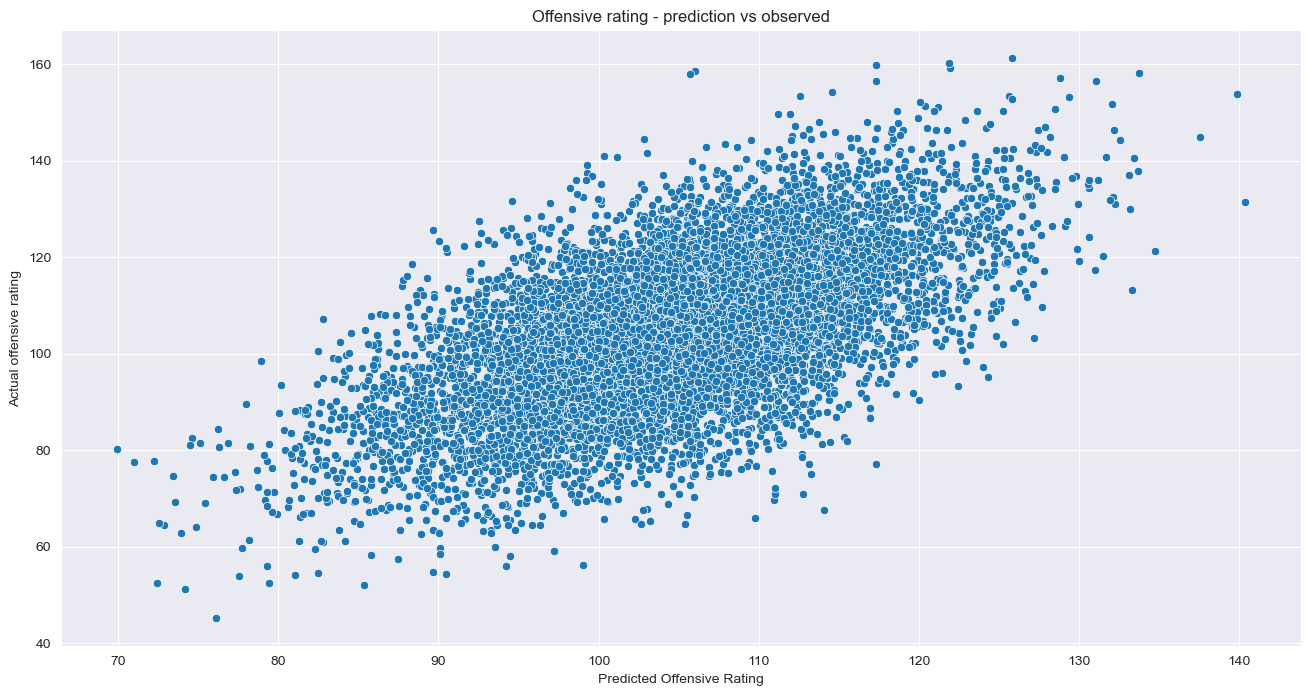

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
sns.scatterplot(x = games_df.predicted_ortg,y = games_df.actual_ortg)
plt.title("Offensive rating - prediction vs observed")
plt.xlabel("Predicted Offensive Rating")
plt.ylabel("Actual offensive rating")
plt.show();

In [35]:
team_dict = parameter_dict['regression_dict'].copy()
team_dict['ALABAMA']

{'intercept_ortg': 104.49,
 'coef_ortg': 20.983388027990515,
 'adj_ortg': 125.47373372764972,
 'intercept_drtg': 104.49,
 'coef_drtg': -7.0494002872167005,
 'adj_drtg': 97.4409454124421,
 'intercept_pace': 68.97,
 'coef_pace': 4.827712502580007,
 'adj_pace': 73.7940862243459,
 'adj_nrtg': 28.03278831520761}

In [49]:
def generate_expected_efficiencies(reg_output_dict:dict,
                                team_1:str,
                                team_2: str,
                                home_team: str = None) -> tuple:
    for team in [team_1,team_2,home_team]:
        if team is None:
            continue
        if team.upper() in reg_output_dict:
            continue
        raise ValueError(f"'{team.upper()}' is not a recognized team name")
    
    efficiency_avg = reg_output_dict.get(team_1.upper()).get('intercept_ortg')
    team_1_offense_coefficient = reg_output_dict.get(team_1.upper()).get('coef_ortg')
    team_1_defense_coefficient = reg_output_dict.get(team_1.upper()).get('coef_drtg')
    team_2_offense_coefficient = reg_output_dict.get(team_2.upper()).get('coef_ortg')
    team_2_defense_coefficient = reg_output_dict.get(team_2.upper()).get('coef_drtg')
    team_1_pace = reg_output_dict.get(team_1.upper()).get("adj_pace")
    team_2_pace = reg_output_dict.get(team_2.upper()).get("adj_pace")
    est_pace = round((team_1_pace * team_2_pace)/reg_output_dict.get(team_1.upper()).get('intercept_pace'),1)
    
    if home_team:
        home_adjustment_factor_offense = reg_output_dict.get('HOME_COURT_ADVANTAGE').get('coef_ortg')
        home_adjustment_factor_defense = reg_output_dict.get('HOME_COURT_ADVANTAGE').get('coef_drtg')
        
        if home_team == team_1:
            team_1_efficiency = efficiency_avg + team_1_offense_coefficient + team_2_defense_coefficient + home_adjustment_factor_offense
            team_2_efficiency = efficiency_avg + team_2_offense_coefficient + team_1_defense_coefficient + home_adjustment_factor_defense
            
            print(f"{team_1}: {efficiency_avg} +{team_1_offense_coefficient:.2f} from {team_1}'s offense + {team_2_defense_coefficient:.2f}"
            f" from {team_2}'s defense + {home_adjustment_factor_offense:.2f} = {team_1_efficiency:.2f}")
            print(f"{team_2}: {efficiency_avg} +{team_2_offense_coefficient:.2f} from {team_2}'s offense + {team_1_defense_coefficient:.2f}"
            f" from {team_1}'s defense + {home_adjustment_factor_defense:.2f} = {team_2_efficiency:.2f}") 
            return team_1_efficiency,team_2_efficiency,est_pace
        else:
            team_1_efficiency = efficiency_avg + team_1_offense_coefficient + team_2_defense_coefficient + home_adjustment_factor_defense
            team_2_efficiency = efficiency_avg + team_2_offense_coefficient + team_1_defense_coefficient + home_adjustment_factor_offense
            
            print(f"{team_1}: {efficiency_avg} +{team_1_offense_coefficient:.2f} from {team_1}'s offense + {team_2_defense_coefficient:.2f}"
            f" from {team_2}'s defense + {home_adjustment_factor_defense:.2f} = {team_1_efficiency:.2f}")
            print(f"{team_2}: {efficiency_avg} +{team_2_offense_coefficient:.2f} from {team_2}'s offense + {team_1_defense_coefficient:.2f}"
            f" from {team_1}'s defense + {home_adjustment_factor_offense:.2f} = {team_2_efficiency:.2f}")
            return team_1_efficiency,team_2_efficiency,est_pace
        
    
    team_1_efficiency = efficiency_avg + team_1_offense_coefficient + team_2_defense_coefficient
    team_2_efficiency = efficiency_avg + team_2_offense_coefficient + team_1_defense_coefficient
    print(f"{team_1}: {efficiency_avg} +{team_1_offense_coefficient:.2f} from {team_1}'s offense + {team_2_defense_coefficient:.2f}"
            f" from {team_2}'s defense = {team_1_efficiency:.2f}")
    print(f"{team_2}: {efficiency_avg} +{team_2_offense_coefficient:.2f} from {team_2}'s offense + {team_1_defense_coefficient:.2f}"
    f" from {team_1}'s defense = {team_2_efficiency:.2f}")
    print(est_pace)
    return team_1_efficiency,team_2_efficiency,est_pace

off_1,off_2,pace = generate_expected_efficiencies(team_dict,"Purdue","Michigan","Michigan")
print(f"Purdue: {(off_1 / 100) * pace:.0f}")
print(f"Michigan: {(off_2 / 100) * pace:.0f}")

Purdue: 104.49 +20.30 from Purdue's offense + 0.16 from Michigan's defense + -2.65 = 122.30
Michigan: 104.49 +5.46 from Michigan's offense + -10.82 from Purdue's defense + 2.65 = 101.78
Purdue: 84
Michigan: 70
